# Analyzing Fantasy Football Data

In [8]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

## Importing Data

In [20]:
# instantiate players dataframe
players = pd.DataFrame()

# read in weekly player data
base_path = 'https://raw.githubusercontent.com/fantasydatapros/data/master/weekly/'
for year in range(2018, 2021):
   year_path = base_path + str(year) + '/'
   for week in range(1, 18):
      week_path = year_path + 'week' + str(week) + '.csv'
      temp = pd.read_csv(week_path)
      temp.insert(1, 'Week', week)
      temp.insert(2, 'Year', year)
      players = pd.concat([players, temp], ignore_index=True)

# drop irrelevant columns
players.drop(columns=['PPRFantasyPoints', 'StandardFantasyPoints', 'Unnamed: 0'], inplace=True)

# view first few rows
players.head()

In [145]:
recent = players[players['Year'] == 2020].sort_values('FantasyPoints', ascending=False).reset_index().drop('index', axis=1)

## Exploring Fantasy Point Distributions by Position

In [154]:
def playerLookup(name, df):
    return df[df['Player'] == name]

### Running Backs

In [165]:
recent.head()

,Player,Year,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Int,Fumbles,FumblesLost
0,Josh Allen,2020,BUF,QB,24.0,16.0,16.0,1.0,1.0,4544.0,...,572.0,421.0,8.0,102.0,12.0,1.0,395.56,10.0,9.0,6.0
1,Aaron Rodgers,2020,GNB,QB,37.0,16.0,16.0,1.0,1.0,4299.0,...,526.0,149.0,3.0,38.0,-6.0,0.0,382.76,5.0,4.0,2.0
2,Kyler Murray,2020,ARI,QB,23.0,16.0,16.0,0.0,0.0,3971.0,...,558.0,819.0,11.0,133.0,0.0,0.0,378.74,12.0,9.0,4.0
3,Patrick Mahomes,2020,KAN,QB,25.0,15.0,15.0,2.0,0.0,4740.0,...,588.0,308.0,2.0,62.0,0.0,0.0,368.40,6.0,5.0,2.0
4,Deshaun Watson,2020,HOU,QB,25.0,16.0,16.0,0.0,0.0,4823.0,...,544.0,444.0,3.0,90.0,0.0,0.0,367.32,7.0,8.0,3.0


In [248]:
recent_rb = recent[recent['Pos'] == 'RB']

rb_loc, rb_scale = norm.fit(recent_rb.FantasyPoints)
print('rb_loc = {0}\trb_scale = {1}'.format(rb_loc, rb_scale))

recent_rb_cdf = norm.cdf(recent_rb.FantasyPoints, loc=rb_loc, scale=rb_scale)

rb_loc = 66.54773006134968	rb_scale = 71.67918322021615


In [249]:
recent_wr = recent[recent['Pos'] == 'WR']

wr_loc, wr_scale = norm.fit(recent_wr.FantasyPoints)
print('wr_loc = {0}\twr_scale = {1}'.format(wr_loc, wr_scale))

recent_wr_cdf = norm.cdf(recent_wr.FantasyPoints, loc=wr_loc, scale=wr_scale)

wr_loc = 70.19881278538813	wr_scale = 68.29558384712547


In [250]:
recent_qb = recent[recent['Pos'] == 'QB']

qb_loc, qb_scale = norm.fit(recent_qb.FantasyPoints)
print('qb_loc = {0}\tqb_scale = {1}'.format(qb_loc, qb_scale))

recent_qb_cdf = norm.cdf(recent_qb.FantasyPoints, loc=qb_loc, scale=qb_scale)

qb_loc = 112.98987951807229	qb_scale = 125.63045284929133


In [251]:
recent_te = recent[recent['Pos'] == 'TE']

te_loc, te_scale = norm.fit(recent_te.FantasyPoints)
print('te_loc = {0}\tte_scale = {1}'.format(te_loc, te_scale))

recent_te_cdf = norm.cdf(recent_te.FantasyPoints, loc=te_loc, scale=te_scale)

te_loc = 45.947610619469025	te_scale = 48.35060943094676


Text(0.5, 1.0, 'Cumulative Distribution Functions of Fantasy Points across Positions in 2020')

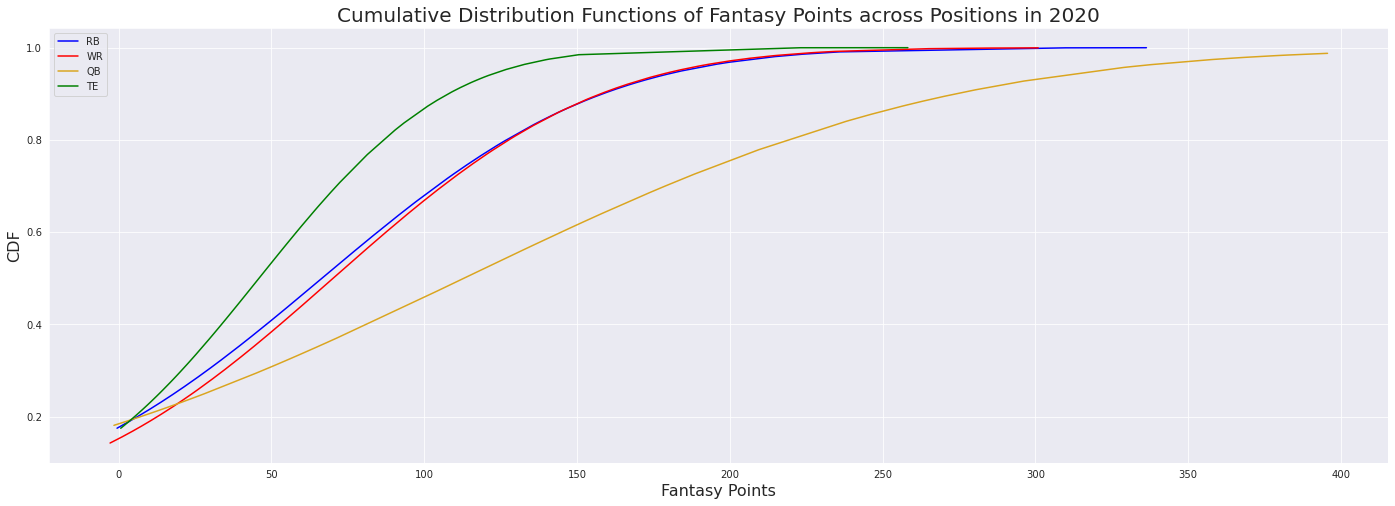

In [271]:
fig, ax = plt.subplots(1, figsize=(24,8))

sns.lineplot(x=recent_rb.FantasyPoints, y=recent_rb_cdf, ax=ax, color='blue', label='RB')
sns.lineplot(x=recent_wr.FantasyPoints, y=recent_wr_cdf, ax=ax, color='red', label='WR')
sns.lineplot(x=recent_qb.FantasyPoints, y=recent_qb_cdf, ax=ax, color='goldenrod', label='QB')
sns.lineplot(x=recent_te.FantasyPoints, y=recent_te_cdf, ax=ax, color='green', label='TE')

ax.legend(loc='upper left')
ax.set_xlabel('Fantasy Points', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.set_title('Cumulative Distribution Functions of Fantasy Points across Positions in 2020', fontsize=20)

In [275]:
norm.ppf(0.9, loc=wr_loc, scale=wr_scale)

157.7231251844543

In [ ]:
players[players['Pos'] == 'RB'].

In [273]:
rb = players[players['Pos'] == 'RB']
rb_fp = rb.groupby('Player')['FantasyPoints'].mean()
rb_fp.sort_values(ascending=False)

Player
Alvin Kamara           280.980
Ezekiel Elliott        254.120
Christian McCaffrey    253.425
Todd Gurley            235.850
Jonathan Taylor        234.800
                        ...   
Bralon Addison           0.000
Devante Mays            -0.400
Brandon Burks           -0.400
Adrian Killins          -0.500
Glenn Winston           -2.800
Name: FantasyPoints, Length: 370, dtype: float64

In [121]:
wr = players[players['Pos'] == 'WR']
wr_fp = wr.groupby('Player')['FantasyPoints'].mean()
wr_fp.sort_values(ascending=False)

Player
DeAndre Hopkins     235.773333
Justin Jefferson    226.200000
Julio Jones         223.666667
Tyreek Hill         219.880000
Calvin Johnson      217.400000
                       ...    
JJ Jones             -1.200000
Michael Walker       -1.500000
Matthew Slater       -1.500000
Kendall Hinton       -2.780000
Marcus Thigpen       -4.100000
Name: FantasyPoints, Length: 485, dtype: float64

In [122]:
qb = players[players['Pos'] == 'QB']
qb_fp = qb.groupby('Player')['FantasyPoints'].mean()
qb_fp.sort_values(ascending=False)

Player
Kyler Murray      329.010000
Justin Herbert    328.840000
Russell Wilson    321.423333
Lamar Jackson     301.333333
Deshaun Watson    295.590000
                     ...    
Tim Boyle          -0.500000
Tyler Bray         -0.640000
Jake Rudock        -1.040000
Sean Renfree       -1.960000
Kyle Lauletta      -2.200000
Name: FantasyPoints, Length: 152, dtype: float64

In [123]:
te = players[players['Pos'] == 'TE']
te_fp = te.groupby('Player')['FantasyPoints'].mean()
te_fp.sort_values(ascending=False)

Player
Travis Kelce        204.526667
Gary Barnidge       149.250000
Zach Ertz           148.700000
Rob Gronkowski      145.900000
George Kittle       144.700000
                       ...    
Zach Gentry           0.900000
Ryan Malleck          0.800000
Marcus Baugh          0.700000
Asante Cleveland      0.600000
David Johnson        -0.700000
Name: FantasyPoints, Length: 245, dtype: float64

In [2]:
defense = pd.read_html('http://www.fantasypros.com/nfl/points-allowed.php?year=2020')

row_indices = [i for i in range(1, 64, 2)]
defense = defense[0].drop(row_indices, axis=0).reset_index()